<a href="https://colab.research.google.com/github/lonespear/aerogel/blob/main/fiberL_v8_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from skimage.morphology import skeletonize
from scipy.spatial import cKDTree
import random
import requests

def anisotropic_diffusion(
    img, niter=1, kappa=50, gamma=0.1, voxelspacing=None, option=1
):
    r"""
    Edge-preserving, XD Anisotropic diffusion.

    To achieve the best effects, the image should be scaled to
    values between 0 and 1 beforehand.


    Parameters
    ----------
    img : array_like
        Input image (will be cast to numpy.float).
    niter : integer
        Number of iterations.
    kappa : integer
        Conduction coefficient, e.g. 20-100. ``kappa`` controls conduction
        as a function of the gradient. If ``kappa`` is low small intensity
        gradients are able to block conduction and hence diffusion across
        steep edges. A large value reduces the influence of intensity gradients
        on conduction.
    gamma : float
        Controls the speed of diffusion. Pick a value :math:`<= .25` for stability.
    voxelspacing : tuple of floats or array_like
        The distance between adjacent pixels in all img.ndim directions
    option : {1, 2, 3}
        Whether to use the Perona Malik diffusion equation No. 1 or No. 2,
        or Tukey's biweight function.
        Equation 1 favours high contrast edges over low contrast ones, while
        equation 2 favours wide regions over smaller ones. See [1]_ for details.
        Equation 3 preserves sharper boundaries than previous formulations and
        improves the automatic stopping of the diffusion. See [2]_ for details.

    Returns
    -------
    anisotropic_diffusion : ndarray
        Diffused image.

    Notes
    -----
    Original MATLAB code by Peter Kovesi,
    School of Computer Science & Software Engineering,
    The University of Western Australia,
    pk @ csse uwa edu au,
    <http://www.csse.uwa.edu.au>

    Translated to Python and optimised by Alistair Muldal,
    Department of Pharmacology,
    University of Oxford,
    <alistair.muldal@pharm.ox.ac.uk>

    Adapted to arbitrary dimensionality and added to the MedPy library Oskar Maier,
    Institute for Medical Informatics,
    Universitaet Luebeck,
    <oskar.maier@googlemail.com>

    June 2000  original version. -
    March 2002 corrected diffusion eqn No 2. -
    July 2012 translated to Python -
    August 2013 incorporated into MedPy, arbitrary dimensionality -

    References
    ----------
    .. [1] P. Perona and J. Malik.
       Scale-space and edge detection using ansotropic diffusion.
       IEEE Transactions on Pattern Analysis and Machine Intelligence,
       12(7):629-639, July 1990.
    .. [2] M.J. Black, G. Sapiro, D. Marimont, D. Heeger
       Robust anisotropic diffusion.
       IEEE Transactions on Image Processing,
       7(3):421-432, March 1998.
    """
    # define conduction gradients functions
    if option == 1:

        def condgradient(delta, spacing):
            return np.exp(-((delta / kappa) ** 2.0)) / float(spacing)

    elif option == 2:

        def condgradient(delta, spacing):
            return 1.0 / (1.0 + (delta / kappa) ** 2.0) / float(spacing)

    elif option == 3:
        kappa_s = kappa * (2**0.5)

        def condgradient(delta, spacing):
            top = 0.5 * ((1.0 - (delta / kappa_s) ** 2.0) ** 2.0) / float(spacing)
            return np.where(np.abs(delta) <= kappa_s, top, 0)

    # initialize output array
    out = np.array(img, dtype=np.float32, copy=True)

    # set default voxel spacing if not supplied
    if voxelspacing is None:
        voxelspacing = tuple([1.0] * img.ndim)

    # initialize some internal variables
    deltas = [np.zeros_like(out) for _ in range(out.ndim)]

    for _ in range(niter):
        # calculate the diffs
        for i in range(out.ndim):
            slicer = tuple(
                [slice(None, -1) if j == i else slice(None) for j in range(out.ndim)]
            )
            deltas[i][tuple(slicer)] = np.diff(out, axis=i)

        # update matrices
        matrices = [
            condgradient(delta, spacing) * delta
            for delta, spacing in zip(deltas, voxelspacing)
        ]

        # subtract a copy that has been shifted ('Up/North/West' in 3D case) by one
        # pixel. Don't as questions. just do it. trust me.
        for i in range(out.ndim):
            slicer = tuple(
                [slice(1, None) if j == i else slice(None) for j in range(out.ndim)]
            )
            matrices[i][tuple(slicer)] = np.diff(matrices[i], axis=i)

        # update the image
        out += gamma * (np.sum(matrices, axis=0))

    return out

def iterative_prune(skel_img, size):
    """Iteratively remove endpoints (tips) from a skeletonized image."""
    def find_tips(skel_img):
        kernel = np.array([[1, 1, 1], [1, 10, 1], [1, 1, 1]], dtype=np.uint8)
        neighbors = cv2.filter2D(skel_img, -1, kernel)
        tips = (neighbors == 11).astype(np.uint8) * 255
        return tips

    pruned_img = skel_img.copy()
    for _ in range(size):
        endpoints = find_tips(pruned_img)
        pruned_img = cv2.subtract(pruned_img, endpoints)

    return pruned_img

def fast_prune(skel_img, size=5):
    pruned_img = skel_img.copy()
    contours, _ = cv2.findContours(skel_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]
    kept_segments = []

    for contour in contours:
        arc_length = cv2.arcLength(contour, closed=False)
        if arc_length > size:  # Keep contours with sufficient arc length
            kept_segments.append(contour)
        else:
            for point in contour:
                pruned_img[point[0][1], point[0][0]] = 0

    pruned_img = iterative_prune(pruned_img, size)
    return pruned_img, kept_segments

def find_branch_points(skel_img):
    """Identify branch points in a skeletonized image.

    Inputs:
    - skel_img: Binary skeletonized image (0 and 255 values).

    Returns:
    - branch_pts_img: Binary image with branch points marked as 255, rest as 0.
    """
    # Define the branch point detection kernels
    t1 = np.array([[-1, 1, -1],
                   [1, 1, 1],
                   [-1, -1, -1]])
    t2 = np.array([[1, -1, 1],
                   [-1, 1, -1],
                   [1, -1, -1]])
    y1 = np.array([[1, -1, 1],
                   [0, 1, 0],
                   [0, 1, 0]])
    y2 = np.array([[-1, 1, -1],
                   [1, 1, 0],
                   [-1, 0, 1]])

    # Rotate the kernels to cover all orientations
    kernels = [t1, t2, y1, y2]
    for _ in range(3):
        kernels += [np.rot90(kernel) for kernel in kernels[-4:]]

    # Create an empty image to store branch points
    branch_pts_img = np.zeros(skel_img.shape, dtype=np.uint8)

    # Apply each kernel with morphological hit-or-miss operation
    for kernel in kernels:
        hit_miss = cv2.morphologyEx(skel_img, cv2.MORPH_HITMISS, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=0)
        branch_pts_img = cv2.bitwise_or(branch_pts_img, hit_miss)

    return branch_pts_img

def calculate_intersection_associations(br_pts, edge_points_list, proximity_threshold=15):
    """
    Calculate intersection associations by finding nearby edges for each branch point.

    Args:
        br_pts: List of branch points (x, y).
        edge_points_list: List of edge points for all edges.
        proximity_threshold: Maximum distance for association.

    Returns:
        intersection_associations: A dictionary mapping branch point indices to associated edge indices.
    """
    intersection_associations = {}
    for br_index, br_point in enumerate(br_pts):
        print(f"Branch Point {br_index}: {br_point}")
        associated_edges = []
        for edge_index, edge_points in enumerate(edge_points_list):
            # Calculate distances from branch point to all points in the edge
            distances = np.linalg.norm(edge_points - br_point, axis=1)
            min_distance = np.min(distances)

            # Check proximity
            if min_distance <= proximity_threshold:
                print(f"  Edge {edge_index} is close to Branch Point {br_index} (distance: {min_distance})")
                associated_edges.append(edge_index)

        intersection_associations[br_index] = associated_edges
    return intersection_associations


def calculate_edge_connections(intersection_associations, edge_points_list, br_pts):
    """
    Calculate edge connections based on cosine similarity to identify the most aligned pair of edges.

    Args:
        intersection_associations: A dictionary mapping branch point indices to associated edge indices.
        edge_points_list: List of edge points for all edges.
        br_pts: List of branch points (x, y).

    Returns:
        branch_connections: A dictionary mapping branch point indices to the pair of connected edges.
    """
    branch_connections = {}

    for br_index, associated_edges in intersection_associations.items():
        print(f"Branch Point {br_index} associated edges: {associated_edges}")

        # Ensure at least two edges to form a connection
        if len(associated_edges) < 2:
            print(f"Branch Point {br_index} has fewer than 2 edges! This should not happen.")
            continue

        br_point = np.array(br_pts[br_index])
        vectors = []

        # Calculate direction vectors for all associated edges
        for edge_index in associated_edges:
            edge_points = edge_points_list[edge_index]
            distances = np.linalg.norm(edge_points - br_point, axis=1)
            closest_idx = np.argmin(distances)

            # Determine direction vector based on the closest endpoint
            if closest_idx == 0:
                direction_vector = edge_points[1] - edge_points[0]
            elif closest_idx == len(edge_points) - 1:
                direction_vector = edge_points[-1] - edge_points[-2]
            else:
                # Should not happen since we are dealing with endpoints
                continue

            # Normalize the direction vector
            if np.linalg.norm(direction_vector) > 0:
                direction_vector = direction_vector / np.linalg.norm(direction_vector)
                vectors.append((edge_index, direction_vector))

        # If there are only two vectors, return them directly
        if len(vectors) == 2:
            branch_connections[br_index] = (vectors[0][0], vectors[1][0])
            continue

        # Compare cosine similarity between all pairs of vectors
        best_pair = None
        best_similarity = -float('inf')  # Start with the lowest possible similarity
        for i in range(len(vectors)):
            for j in range(i + 1, len(vectors)):
                idx1, v1 = vectors[i]
                idx2, v2 = vectors[j]

                # Cosine similarity (dot product gives cosine value directly)
                similarity = np.dot(v1, v2)

                # Update best pair if this similarity is higher
                if similarity > best_similarity:
                    best_similarity = similarity
                    best_pair = (idx1, idx2)

        # Ensure a best pair is selected
        if best_pair is None:
            # Fallback: arbitrarily pick the first two edges
            best_pair = (vectors[0][0], vectors[1][0])

        # Store the best-connected pair for this branch point
        branch_connections[br_index] = best_pair
        print(f"Branch Point {br_index}: Best Pair = {best_pair} with similarity = {best_similarity}")

    return branch_connections




# Union-Find Helper Functions
class UnionFind:
    def __init__(self):
        self.parent = {}

    def find(self, x):
        if x not in self.parent:
            self.parent[x] = x
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])  # Path compression
        return self.parent[x]

    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)
        if root_x != root_y:
            self.parent[root_y] = root_x

# Improved Grouping Logic
def merge_edges(edge_points_list, branch_connections):
    uf = UnionFind()
    for edges in branch_connections.values():
        for i in range(len(edges) - 1):
            uf.union(edges[i], edges[i + 1])

    # Create groups of connected edges
    grouped_edges = {}
    for idx, edge in enumerate(edge_points_list):
        root = uf.find(idx)
        if root not in grouped_edges:
            grouped_edges[root] = []
        grouped_edges[root].append(edge)

    # Merge edges in each group
    new_edge_objects = []
    for group_edges in grouped_edges.values():
        concatenated_edges = np.concatenate(group_edges, axis=0)
        new_edge_objects.append(concatenated_edges)

    return new_edge_objects

def sort_by_proximity(edge_points):
    sorted_points = [edge_points[0]]  # Start with the first point
    edge_points = edge_points[1:]    # Remove it from the list
    while len(edge_points) > 0:
        # Find the nearest point to the last point in sorted_points
        last_point = sorted_points[-1]
        distances = np.linalg.norm(edge_points - last_point, axis=1)
        nearest_idx = np.argmin(distances)
        sorted_points.append(edge_points[nearest_idx])
        edge_points = np.delete(edge_points, nearest_idx, axis=0)
    return np.array(sorted_points)

def draw_edge_objects(edge_objects, image_shape, thickness=1):
    color_image = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.uint8)
    for edge in edge_objects:
        color = [random.randint(0, 255) for _ in range(3)]
        cv2.drawContours(color_image, [edge], -1, color, thickness=thickness, lineType=cv2.LINE_AA)
    return color_image

# Combined Density Plot and Histogram
def plot_density_histogram(data, ax):
    sns.histplot(data, bins=20, ax=ax, kde=True, color='steelblue', edgecolor='black')
    ax.set_title("Density and Histogram of Arc Lengths")
    ax.set_xlabel("Arc Length")
    ax.set_ylabel("Density / Frequency")

# Boxplot
def plot_boxplot(data, ax):
    sns.boxplot(data=data, ax=ax, color='lightblue')
    ax.set_title("Boxplot of Arc Lengths")
    ax.set_xlabel("Arc Length")

# Updated Visualization
def visualize_results(fib_image, skeletonized_img1, blurred_img, color_image, arc_lengths):
    fig, axes = plt.subplots(3, 2, figsize=(12, 12), constrained_layout=True)

    # Plot Original Image
    axes[0, 0].imshow(fib_image, cmap='gray')
    axes[0, 0].set_title("Original Image")

    # Plot Skeletonized Image
    axes[0, 1].imshow(skeletonized_img1, cmap='gray')
    axes[0, 1].set_title("Skeletonized Image (Linewidth Approx.)")

    # Plot Blurred Image
    axes[1, 0].imshow(blurred_img, cmap='gray')
    axes[1, 0].set_title("Blurred Image")

    # Plot Final Colored Image
    axes[1, 1].imshow(color_image)
    axes[1, 1].set_title("Final Colored Edge Network")

    # Combined Density and Histogram Plot
    plot_density_histogram(arc_lengths, axes[2, 0])

    # Boxplot
    plot_boxplot(arc_lengths, axes[2, 1])

    # Hide unused axes (if any)
    for ax in axes.flatten():
        ax.axis('on')  # Ensure all axes are turned on
    plt.show()

def proc_img(image_data, dim=1600):
    # Decode the image and convert it to grayscale
    og_img = cv2.imdecode(image_data, cv2.IMREAD_GRAYSCALE)
    # Snip off the dataribbon (later will need the dataribbon to identify scale for fiber length)
    fib_image = og_img[:3750,:]
    # Square cutout for processing (doesn't have to be square is my hunch)
    fib_image = fib_image[0:dim,0:dim]
    # Anisotropic diffusion first to adaptively eliminate noise while maintaining edge information
    diff_img = anisotropic_diffusion(fib_image, niter=50, kappa=20, gamma=0.1, option=1)
    # Initial thresholding cutoff in preparation for skeletonization, the second parameter will increase/decrease sensitivity
    _, thresholded_img = cv2.threshold(diff_img, 127, 255, 0)

    # Main loop for initial pass at skeletonization
    skel = np.zeros(thresholded_img.shape, np.uint8)                              # Creates blank canvas to store skeletonized image
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))                  # Generates kernel to pass through each section of image
    while True:
        open_img = cv2.morphologyEx(thresholded_img, cv2.MORPH_OPEN, element)     # Fit open-cross kernel to thresholded image
        temp = cv2.subtract(thresholded_img, open_img)                            # Subtracts the above from the original image
        temp = temp.astype(skel.dtype)                                            # Convert temp from 32-bit to 8bit datatype
        skel = cv2.bitwise_or(skel, temp)                                         # aggregates and compares both original and above created image
        thresholded_img = cv2.erode(thresholded_img, element)                     # degrades the width of the image by 1 pixel
        if cv2.countNonZero(thresholded_img) == 0:                                # conditional exits if there are no more remaining iterations to pass through
            break
    skeletonized_img1 = skel.copy()

    # Gaussian blur using 25x25 kernel
    blurred_img = cv2.GaussianBlur(skel, (25, 25), 0)
    # Very light noise removal (using 15 instead of 127 above here)
    _, bin_img = cv2.threshold(blurred_img, 15, 255, cv2.THRESH_BINARY)
    # Use standard skeletonization from cv2 package and convert final image output.
    skeletonized_img2 = skeletonize(bin_img // 255).astype(np.uint8) * 255

    branch_pts_img = find_branch_points(skeletonized_img2)
    branch_pts = np.argwhere(branch_pts_img != 0)
    # Create a kernel for dilation (3x3 kernel in this example, adjust as needed)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # Apply dilation using the kernel
    bp = cv2.dilate(branch_pts_img, kernel, iterations=1)

    # Subtract from the skeleton so that leaves are no longer connected
    segments = cv2.subtract(skeletonized_img2, bp)

    # Segmentation function that also will remove identified objects less than size specified.
    pruned_skel, edge_objects = fast_prune(segments)

    branch_pts = np.array([[pt[1], pt[0]] for pt in branch_pts])  # Convert from [y, x]
    edge_points_list = [np.array([point[0] for point in edge]) for edge in edge_objects]

    print(f"Branch Points: {branch_pts}")
    print(f"Number of Edges: {len(edge_points_list)}")
    for i, edge in enumerate(edge_points_list):
        print(f"Edge {i}: {edge.shape} points")

    # Step 1: Calculate Edge to Intersection Associations
    intersection_associations = calculate_intersection_associations(br_pts=branch_pts,
                                                    edge_points_list=edge_points_list,
                                                    proximity_threshold=5
                                                )

    # Step 2: Build `branch_connections`
    branch_connections = calculate_edge_connections(intersection_associations,
                                                    edge_points_list, branch_pts)

    # Step 3: Merge Edges
    new_edge_objects = merge_edges(edge_points_list, branch_connections)

    # Step 4: Generate Visualization
    color_image = draw_edge_objects(new_edge_objects, image_shape=pruned_skel.shape, thickness=2)
    arc_lengths = [cv2.arcLength(edge, closed=False) for edge in new_edge_objects]

    visualize_results(
        fib_image=fib_image,
        skeletonized_img1=skeletonized_img1,
        blurred_img=blurred_img,
        color_image=color_image,
        arc_lengths=arc_lengths
    )

    # Print stats and return results
    print("Number of branch points:", len(branch_pts))
    print("Number of Intersection Associations:", len(intersection_associations))
    print("Number of Branch Connections: ", len(branch_connections))
    print("Average Fiber Length:", np.mean(arc_lengths))

    return pruned_skel, edge_objects, new_edge_objects, branch_pts, intersection_associations, branch_connections, color_image

In [2]:
# URL of the file
url = "https://github.com/lonespear/aerogel/raw/main/aerogel_co_50mM_magnet_0016.tif"
# Fetch the image from the URL and convert to numpy array
img_data = np.asarray(bytearray(requests.get(url).content), dtype="uint8")
pruned_skel, old_edge_objects, new_edge_objects, branch_pts, intersection_associations, branch_connections, color_image = proc_img(img_data, 200)

Branch Points: [[ 15  49]
 [ 56  59]
 [ 66  73]
 [113  79]
 [ 97  82]
 [ 34 102]
 [ 99 172]
 [ 69 178]
 [110 181]]
Number of Edges: 20
Edge 0: (40, 2) points
Edge 1: (38, 2) points
Edge 2: (14, 2) points
Edge 3: (52, 2) points
Edge 4: (12, 2) points
Edge 5: (84, 2) points
Edge 6: (140, 2) points
Edge 7: (60, 2) points
Edge 8: (136, 2) points
Edge 9: (168, 2) points
Edge 10: (24, 2) points
Edge 11: (68, 2) points
Edge 12: (54, 2) points
Edge 13: (12, 2) points
Edge 14: (20, 2) points
Edge 15: (74, 2) points
Edge 16: (26, 2) points
Edge 17: (74, 2) points
Edge 18: (24, 2) points
Edge 19: (352, 2) points
Branch Point 0: [15 49]
  Edge 15 is close to Branch Point 0 (distance: 2.8284271247461903)
  Edge 16 is close to Branch Point 0 (distance: 2.0)
  Edge 18 is close to Branch Point 0 (distance: 2.23606797749979)
Branch Point 1: [56 59]
  Edge 14 is close to Branch Point 1 (distance: 2.8284271247461903)
  Edge 15 is close to Branch Point 1 (distance: 2.0)
Branch Point 2: [66 73]
  Edge 11 i

IndexError: list index out of range

In [ ]:
intersection_associations

{0: [15, 16, 18],
 1: [14, 15],
 2: [11, 12, 14],
 3: [9, 10, 17],
 4: [8, 10, 12],
 5: [7, 8, 11],
 6: [2, 3, 6],
 7: [1, 3, 4],
 8: [0, 2, 5]}

In [4]:
img = cv2.imdecode(img_data, cv2.IMREAD_GRAYSCALE)

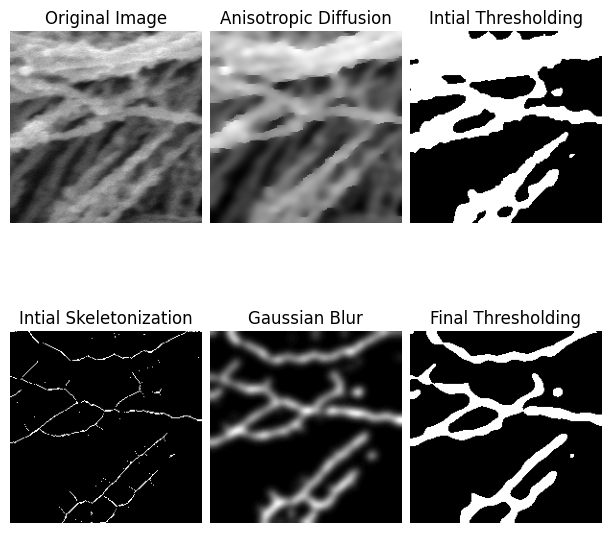

In [4]:
img = cv2.imdecode(img_data, cv2.IMREAD_GRAYSCALE)
# Assuming 'img' is your original image
original_img = img[0:200, 0:200]  # Cropped original image

# Apply anisotropic diffusion
processed_img = anisotropic_diffusion(original_img, niter=50, kappa=20, gamma=0.1, option=1)

# Initial thresholding on Anisotropic diffusion
_, thresholded_img1 = cv2.threshold(processed_img, 127, 255, 0)

thresholded_img = thresholded_img1.copy()

# Main loop for initial pass at skeletonization
skel = np.zeros(thresholded_img.shape, np.uint8)                              # Creates blank canvas to store skeletonized image
element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))                  # Generates kernel to pass through each section of image
while True:
    open_img = cv2.morphologyEx(thresholded_img, cv2.MORPH_OPEN, element)     # Fit open-cross kernel to thresholded image
    temp = cv2.subtract(thresholded_img, open_img)                            # Subtracts the above from the original image
    temp = temp.astype(skel.dtype)                                            # Convert temp from 32-bit to 8bit datatype
    skel = cv2.bitwise_or(skel, temp)                                         # aggregates and compares both original and above created image
    thresholded_img = cv2.erode(thresholded_img, element)                     # degrades the width of the image by 1 pixel
    if cv2.countNonZero(thresholded_img) == 0:                                # conditional exits if there are no more remaining iterations to pass through
        break
skeletonized_img1 = skel.copy()

# Gaussian blur using 25x25 kernel
blurred_img = cv2.GaussianBlur(skel, (25, 25), 0)
# Very light noise removal (using 15 instead of 127 above here)
_, bin_img = cv2.threshold(blurred_img, 15, 255, cv2.THRESH_BINARY)

# Create the subplot
fig, axes = plt.subplots(2, 3, figsize=(6, 6), constrained_layout=True)

# Original image
axes[0,0].imshow(original_img, cmap='gray')
axes[0,0].set_title('Original Image')
axes[0,0].axis('off')

# Anis Diff image
axes[0,1].imshow(processed_img, cmap='gray')
axes[0,1].set_title('Anisotropic Diffusion')
axes[0,1].axis('off')

# Init Thresh image
axes[0,2].imshow(thresholded_img1, cmap='gray')
axes[0,2].set_title('Intial Thresholding')
axes[0,2].axis('off')

# Init Thresh image
axes[1,0].imshow(skeletonized_img1, cmap='gray')
axes[1,0].set_title('Intial Skeletonization')
axes[1,0].axis('off')

# Init Thresh image
axes[1,1].imshow(blurred_img, cmap='gray')
axes[1,1].set_title('Gaussian Blur')
axes[1,1].axis('off')

# Init Thresh image
axes[1,2].imshow(bin_img, cmap='gray')
axes[1,2].set_title('Final Thresholding')
axes[1,2].axis('off')

# Show the plot
plt.show()

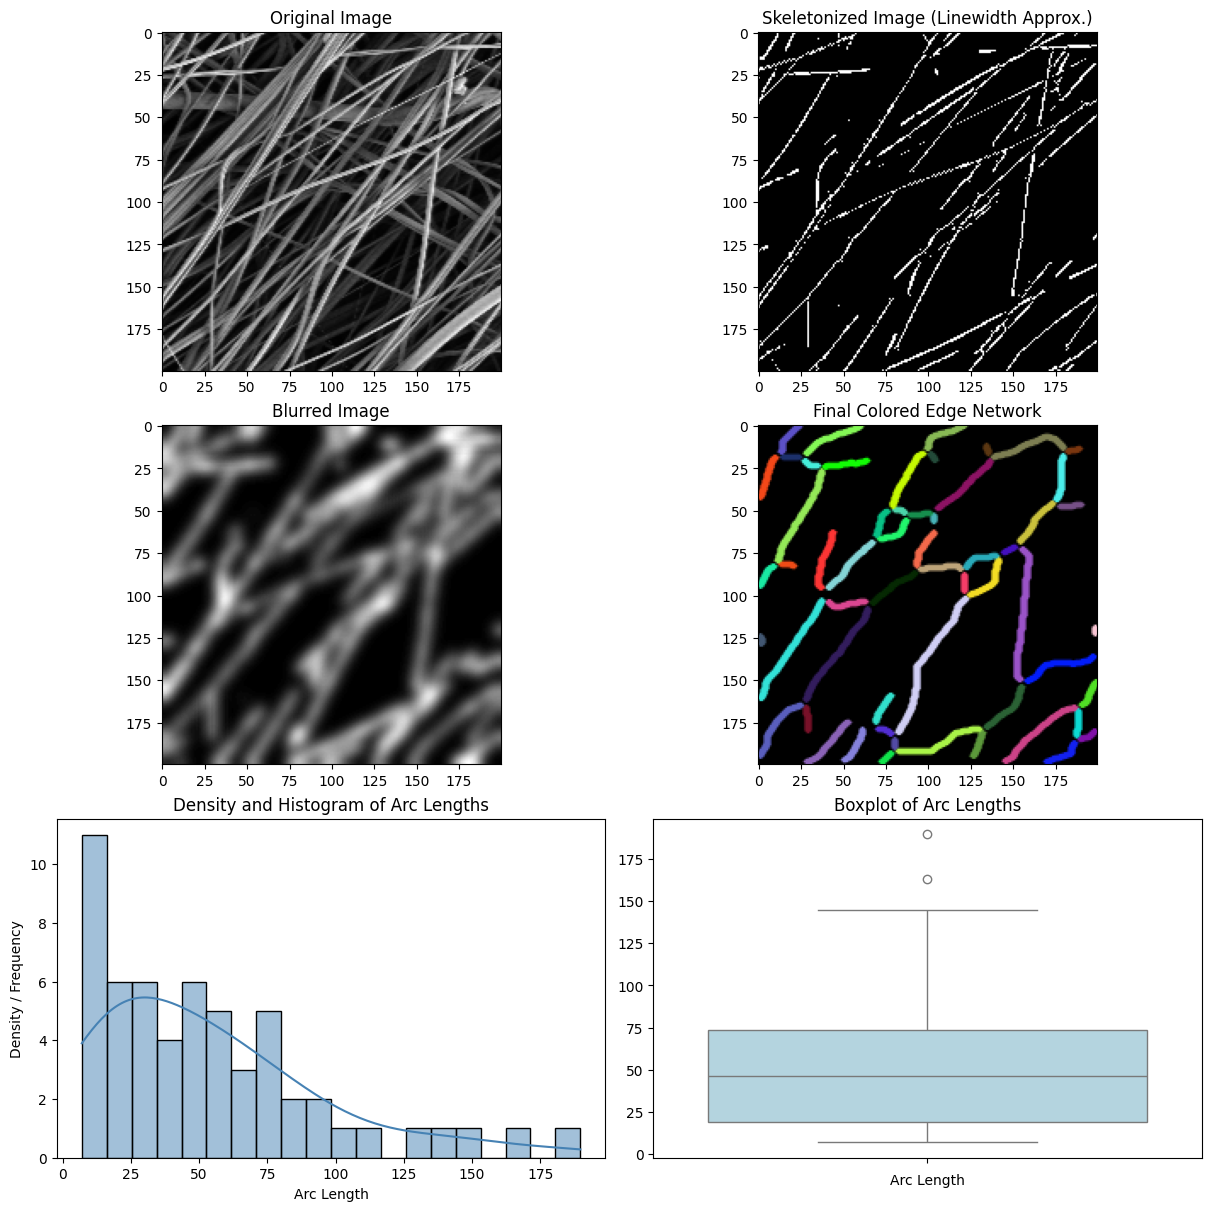

Number of branch points: 32
Number of Intersection Associations: 32
Number of Branch Connections:  0
Average Fiber Length: 53.65320826413338
Insufficient Points Count: 0


In [ ]:
# URL of the file
url = "https://github.com/lonespear/aerogel/raw/main/highalign_PLCCLgel_500x_13.tif"
# Fetch the image from the URL and convert to numpy array
img_data = np.asarray(bytearray(requests.get(url).content), dtype="uint8")
pruned_skel, old_edge_objects, new_edge_objects, branch_pts, intersection_associations, branch_connections, color_image = proc_img(img_data, 200)